In [2]:
from matplotlib import pyplot as plt
import numpy as np
import h5py 
import yaml
import datetime
import os
import h5py
from tqdm import tqdm
from sklearn.decomposition import PCA
import json

In [3]:
def get_all_channel_mean(unique, data):
    u = np.array(list(set(unique)))
    d = np.zeros(len(u))
    iun=0
    for un in tqdm(u):
        mask = unique==un
        d[iun] = np.mean(data[mask])
        iun+=1
        
    return u, d

def get_all_channel_std(unique, data):
    u = np.array(list(set(unique)))
    d = np.zeros(len(u))
    iun=0
    for un in tqdm(u):
        mask = unique==un
        d[iun] = np.std(data[mask])
        iun+=1
        
    return u, d

def get_all_channel_count(unique, data):
    u = np.array(list(set(unique)))
    d = np.zeros(len(u))
    iun=0
    for un in tqdm(u):
        mask = unique==un
        d[iun] = np.sum(mask.astype(int))
        iun+=1
        
    return u, d
 
def display_1d(c,title=None):
    fig = plt.figure(figsize=(12, 10) )
    ax = fig.add_subplot()
    ax.hist(c, bins=50, range=(0, 100))
    ax.set_xlabel('dataword [adc]', fontsize=12)
    ax.grid()
    if not title is None: ax.set_title(title)
    plt.show()
    
def display_2d(x, y, c, title=None, cut=None):
    fig = plt.figure(figsize=(12, 10) )
    ax = fig.add_subplot()
    mask = [True]*len(c)
    if not cut is None:
        mask = c < cut
    
    sc = ax.scatter(x[mask], y[mask], c=c[mask], marker='s', s=40)
    #ax.axhline(50, color='red')

    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('dataword', rotation=270)
    if not title is None: ax.set_title(title)
    plt.show()
    
def display_3d(x, y, z, c, title=None, view=None):
    fig = plt.figure(figsize=(6, 5) )
    ax = fig.add_subplot(projection='3d')
    sc = ax.scatter(x, y, z, c=c, marker='.', s=20, alpha=0.85)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('charge [ke-]', rotation=270, fontsize=14)
    if not view is None:
        ax.view_init(*view)
    
    ax.set_xlabel('x [mm]', fontsize=12)
    ax.set_ylabel('y [mm]', fontsize=12)
    ax.set_zlabel('z (drift) [mm]', fontsize=12)
    ax.set_xlim(-150, 150)
    ax.set_ylim(-150, 150)
    #ax.set_zlim(0, 100)
    #ax.set_zlim(0, 5)
    if not title is None: ax.set_title(title)
    plt.show()

In [4]:
data_dict = {}
with open('datafiles_nosync.json', 'r') as f:
    data_dict=json.load(f)
    
N_CHIPS=100
N_CHANNELS=64
def chip_channel_to_index(chip, channel):
    return (chip-11)*N_CHANNELS + channel

bad_files = [
    '/global/cfs/projectdirs/dune/www/data/LBL/SingleCube/Nov2023/simple_v2/simple-2023_12_06_10_55_48_PST.h5',
    '/global/cfs/projectdirs/dune/www/data/LBL/SingleCube/Nov2023/simple_v2/simple-2023_12_05_21_08_23_PST.h5',
    '/global/cfs/projectdirs/dune/www/data/LBL/SingleCube/Nov2023/simple_v2/simple-2023_12_05_20_36_19_PST.h5',
    '/global/cfs/projectdirs/dune/www/data/LBL/SingleCube/Nov2023/simple_v2/simple-2023_12_05_19_22_08_PST.h5',
    '/global/cfs/projectdirs/dune/www/data/LBL/SingleCube/Nov2023/simple_v2/simple-2023_12_05_21_10_23_PST.h5',
    '/global/cfs/projectdirs/dune/www/data/LBL/SingleCube/Nov2023/simple_v2/simple-2023_12_06_08_50_41_PST.h5',
    '/global/cfs/projectdirs/dune/www/data/LBL/SingleCube/Nov2023/simple_v2/simple-2023_12_05_20_42_20_PST.h5',
    '/global/cfs/projectdirs/dune/www/data/LBL/SingleCube/Nov2023/simple_v2/simple-2023_12_05_20_46_20_PST.h5',
    '/global/cfs/projectdirs/dune/www/data/LBL/SingleCube/Nov2023/simple_v2/simple-2023_12_06_11_00_48_PST.h5',
]

In [5]:
nominal_files = []
for ifile in data_dict.keys():
    if data_dict[ifile]['simple_filename'] in bad_files: 
        continue
    if os.path.exists(data_dict[ifile]['simple_filename']):
        if data_dict[ifile]['charge']=='nominal threshold' and data_dict[ifile]['HV']=='15kV':
            nominal_files.append(data_dict[ifile]['simple_filename'])
            
lt_files = []
for ifile in data_dict.keys():
    if data_dict[ifile]['simple_filename'] in bad_files: continue
    if os.path.exists(data_dict[ifile]['simple_filename']):
        if data_dict[ifile]['charge']=='low threshold' and data_dict[ifile]['HV']=='15kV':
            lt_files.append(data_dict[ifile]['simple_filename'])
            
print('FOUND {} FILES'.format(len(nominal_files)))
print('FOUND {} FILES'.format(len(lt_files)))

FOUND 221 FILES
FOUND 12 FILES


In [189]:
# Find channel thresholds for low and nominal threshold data
MAX_NHIT = 10000
count = np.zeros( (6400, MAX_NHIT)  )
for file in tqdm(nominal_files):
    f = h5py.File(file)
    tmask = np.array(f['charge_ts'])%1e7 > 0
    indices = chip_channel_to_index(np.array(f['charge_chipid']).astype(int), np.array(f['charge_chanid']).astype(int))
    for index in set(indices):
        mask = np.logical_and(tmask, indices==index )
        nz = np.count_nonzero(count[index])
        if nz + np.sum(mask) > MAX_NHIT: 
            continue
        count[index][nz : nz+np.sum(mask)] = f['charge_q'][mask]
        
count_lt = np.zeros( (6400, MAX_NHIT)  )
for file in tqdm(lt_files):
    f = h5py.File(file)
    tmask = np.array(f['charge_ts'])%1e7 > 0
    indices = chip_channel_to_index(np.array(f['charge_chipid']).astype(int), np.array(f['charge_chanid']).astype(int))
    for index in set(indices):
        mask = np.logical_and(tmask, indices==index )
        nz = np.count_nonzero(count_lt[index])
        if nz + np.sum(mask) > MAX_NHIT: 
            continue
        count_lt[index][nz : nz+np.sum(mask)] = f['charge_q'][mask]

100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


In [190]:
thresholds = []
for index in tqdm(range(6400)):
    nz = count[index] > 0
    if np.any(nz):
        t = np.percentile(count[index][nz], 0.05 )
        thresholds.append( t )
        
thresholds_lt = []
for index in tqdm(range(6400)):
    nz = count_lt[index] > 0
    if np.any(nz):
        t = np.percentile(count_lt[index][nz], 0.05 )
        thresholds_lt.append( t )

100%|██████████| 6400/6400 [00:00<00:00, 21939.17it/s]


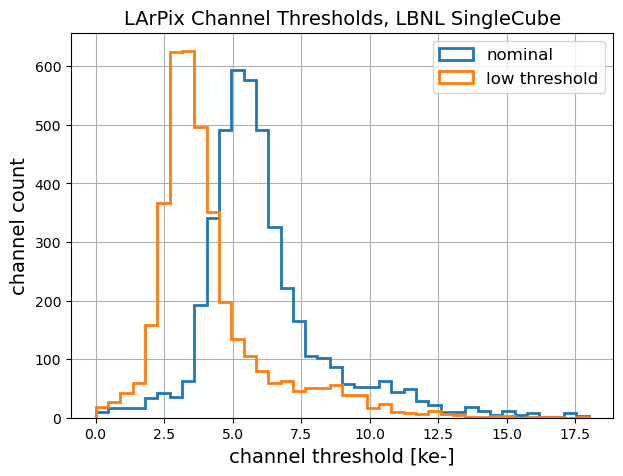

In [191]:
fig=plt.figure(figsize=(7, 5))
plt.hist(thresholds, bins=40, range=(0,18), histtype='step', linewidth=2, label='nominal');
plt.hist(thresholds_lt, bins=40, range=(0,18), histtype='step', linewidth=2, label='low threshold');
plt.xlabel('channel threshold [ke-]', fontsize=14)
plt.ylabel('channel count', fontsize=14)
plt.grid(True)
plt.title('LArPix Channel Thresholds, LBNL SingleCube', fontsize=14)
plt.legend(fontsize=12)

In [33]:
vd = 0.016 #cm/clock cycle
#qs = []
#zs = []
max_ts_diff = int(30.0/vd) #max drift time

for file in tqdm(list(nominal_files)[140:] ):
    continue
    f = h5py.File(file)
    #tmask = np.array(f['charge_ts'])%1e7 > 1
    for evt in set(f['light_event']):
        lmask = f['light_event']==evt
        t0 = np.min(f['light_ts'][lmask])
        mask = np.absolute(f['charge_ts']-t0) < 10*max_ts_diff
        n = sum(mask)
        if n > 0:
            qs += list(f['charge_q'][mask])
            zs += list( (f['charge_ts'][mask] - t0)*vd )
        
qs_low = []
zs_low = []

for file in tqdm( list(lt_files) ):
    f = h5py.File(file)
    #tmask = np.array(f['charge_ts'])%1e7 > 1
    for evt in set(f['light_event']):
        lmask = f['light_event']==evt
        t0 = np.min(f['light_ts'][lmask])
        mask = np.absolute(f['charge_ts']-t0) < 10*max_ts_diff
        n = sum(mask)
        if n > 0:
            qs_low += list(f['charge_q'][mask])
            zs_low += list( (f['charge_ts'][mask] - t0)*vd )

100%|██████████| 12/12 [01:59<00:00,  9.94s/it]


(-200.0, 300.0)

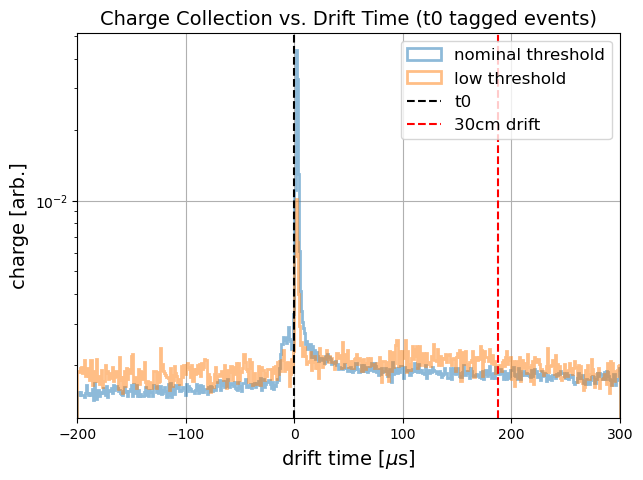

In [34]:
fig=plt.figure(figsize=(7, 5))
ax=fig.add_subplot()
plt.hist(np.array(zs)/vd*0.1, weights=qs, bins=500, range=(-200,300), histtype='step', linewidth=2, label='nominal threshold', density=True, alpha=0.5);
plt.hist(np.array(zs_low)/vd*0.1, weights=qs_low, bins=500, range=(-200,300), histtype='step', linewidth=2, label='low threshold', density=True, alpha=0.5);
plt.xlabel('drift time [$\mu$s]', fontsize=14)
plt.ylabel('charge [arb.]', fontsize=14)
plt.grid(True)
plt.title('Charge Collection vs. Drift Time (t0 tagged events)', fontsize=14)
ax.axvline(0, linestyle='--', color='black', label='t0')
ax.axvline(max_ts_diff*0.1, linestyle='--', color='red', label='30cm drift')
plt.legend(fontsize=12)
plt.yscale('log')
plt.xlim(-200, 300)


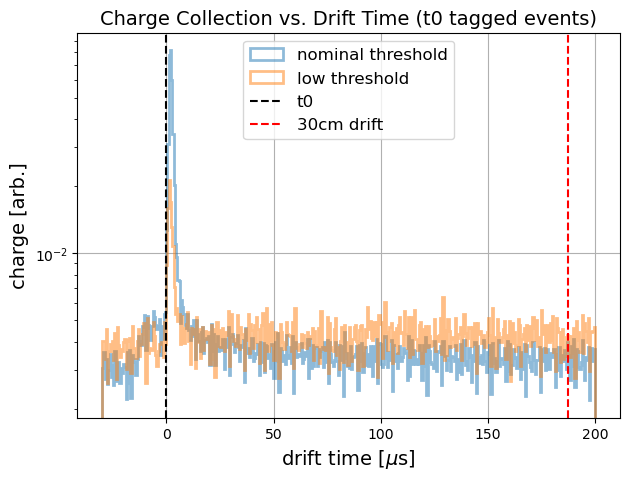

In [44]:
fig=plt.figure(figsize=(7, 5))
ax=fig.add_subplot()
plt.hist(np.array(zs)/vd*0.1, weights=qs, bins=400, range=(-30,200), histtype='step', linewidth=2, label='nominal threshold', density=True, alpha=0.5);
plt.hist(np.array(zs_low)/vd*0.1, weights=qs_low, bins=400, range=(-30,200), histtype='step', linewidth=2, label='low threshold', density=True, alpha=0.5);
plt.xlabel('drift time [$\mu$s]', fontsize=14)
plt.ylabel('charge [arb.]', fontsize=14)
plt.grid(True)
plt.title('Charge Collection vs. Drift Time (t0 tagged events)', fontsize=14)
ax.axvline(0, linestyle='--', color='black', label='t0')
ax.axvline(max_ts_diff*0.1, linestyle='--', color='red', label='30cm drift')
plt.legend(fontsize=12)
plt.yscale('log')
#plt.xlim(-10, 30)


In [ ]:
fig=plt.figure(figsize=(7, 5))
ax=fig.add_subplot()
plt.hist(np.array(zs)/vd*0.1, weights=qs, bins=1000, range=(-1000,2000), histtype='step', linewidth=2, label='nominal threshold', density=True, alpha=0.5);
plt.hist(np.array(zs_low)/vd*0.1, weights=qs_low, bins=1000, range=(-1000,2000), histtype='step', linewidth=2, label='low threshold', density=True, alpha=0.5);
plt.xlabel('drift time [$\mu$s]', fontsize=14)
plt.ylabel('charge [arb.]', fontsize=14)
plt.grid(True)
plt.title('Charge Collection vs. Drift Time (t0 tagged events)', fontsize=14)
ax.axvline(0, linestyle='--', color='black', label='t0')
ax.axvline(max_ts_diff*0.1, linestyle='--', color='red', label='30cm drift')
plt.legend(fontsize=12)
plt.yscale('log')
plt.xlim(-max_ts_diff, max_ts_diff)


In [237]:
vd = 0.016 #cm/clock cycle
#
#pca_mevr = []
#ns = []
#pca_mevr_pre = []
#ns_pre = []
#x = []
#y = []
#q = []

#xp = []
#yp = []
#qp = []

#mdiff = []

max_ts_diff = int(30.0/vd) #max drift time

for file in tqdm(list(nominal_files)[54:]):
    f = h5py.File(file)
    used = np.array(f['charge_ts']) <0
    #print('(charge, light) = ', len(set(f['charge_event'])) , len(set(f['light_event'])) )
    #print('charge - light', len(set(f['charge_event']) - set(f['light_event'])) )
    #print('light - charge', len(set(f['light_event']) - set(f['charge_event'])) )
    
    #Loop for "real" charge [post trigger]
    for evt in set(f['light_event']):
        lmask = f['light_event']==evt
        t0 = np.min(f['light_ts'][lmask])
        tdiff = f['charge_ts']-t0 
        mask = np.logical_and(tdiff > 0, tdiff < max_ts_diff )
        mask = np.logical_and(mask, np.logical_not(used))
        used = np.logical_or(mask, used)
        n = sum(mask)
        ns.append( np.sum(f['charge_q'][mask]) )
        #ns.append(n)
        x += list(f['charge_x'][mask])
        y += list(f['charge_y'][mask])
        q += list(f['charge_q'][mask])
        if n > 4:
            pca = PCA(n_components=3)
            X =  np.array( [f['charge_x'][mask], f['charge_y'][mask], (f['charge_ts'][mask] - t0)*vd*10] ).transpose()
            pca.fit( X - np.mean(X, axis=0) )
            pca_mevr.append( max(pca.explained_variance_ratio_) )
            #display_3d(f['charge_x'][mask], f['charge_y'][mask], (f['charge_ts'][mask] - t0)*vd, f['charge_q'][mask], 
            #          title='{}, Event: {}\nnhits={}\nN_light_hits={}\nMax EVR={:0.4f}'.format(file.split('/')[-1], evt, n, np.sum(lmask), max(pca.explained_variance_ratio_),))  
            
    #Loop for "fake" charge [pre trigger]
    #mask 'used' is the same as above, want to first associate "real" charge
    for ts in sorted(list(set(f['charge_ts'][np.logical_not(used)]))):
        #lmask = f['light_event']==evt
        #t0 = np.min(f['light_ts'][lmask])
        tdiff = np.absolute(f['charge_ts']-ts) 
        mask = tdiff < 2*max_ts_diff
        mask = np.logical_and(mask, np.logical_not(used))
        used = np.logical_or(mask, used)
        n = sum(mask)
        if n > 0: 
            mdiff.append(max(f['charge_ts'][mask]) - min(f['charge_ts'][mask]))
            ns_pre.append( np.sum(f['charge_q'][mask]) )
            xp += list(f['charge_x'][mask])
            yp += list(f['charge_y'][mask])
            qp += list(f['charge_q'][mask])
        if n > 4:
            pca = PCA(n_components=3)
            X =  np.array( [f['charge_x'][mask], f['charge_y'][mask], (f['charge_ts'][mask] - t0)*vd*10] ).transpose()
            pca.fit( X - np.mean(X, axis=0) )
            pca_mevr_pre.append( max(pca.explained_variance_ratio_) )
            #display_3d(f['charge_x'][mask], f['charge_y'][mask], (f['charge_ts'][mask])*vd, f['charge_q'][mask], 
            #          title='{}, Event: {}\nnhits={}\nMax EVR={:0.4f}'.format(file.split('/')[-1], evt, n, max(pca.explained_variance_ratio_),))

100%|██████████| 167/167 [42:34<00:00, 15.29s/it]


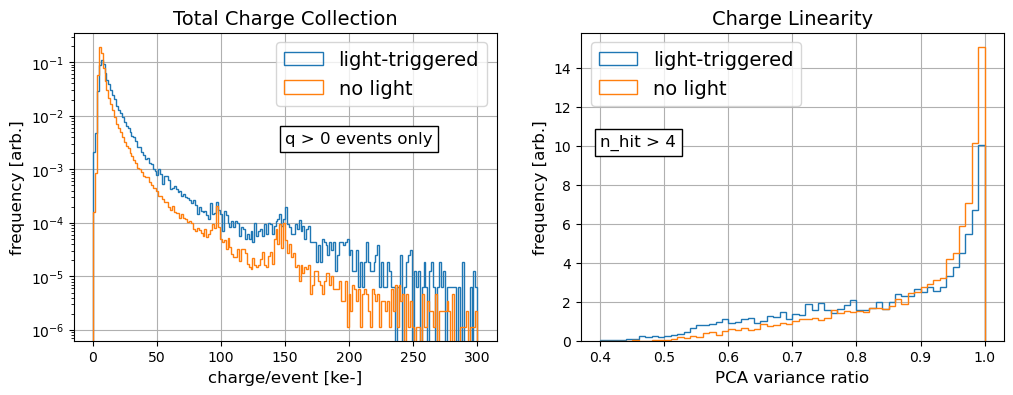

In [421]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(12,4))
ax1.set_title('Charge Linearity',fontsize=14)
ax1.hist(pca_mevr, range=(0.4,1), bins=60, histtype='step', density=True, label='light-triggered')
ax1.hist(pca_mevr_pre, range=(0.4,1), bins=60, histtype='step', density=True, label='no light')
ax1.text(0.4, 10, 'n_hit > 4', fontsize=12, bbox={'edgecolor' : 'black', 'facecolor':'white'})
ax1.set_xlabel('PCA variance ratio', fontsize=12)
ax1.set_ylabel('frequency [arb.]', fontsize=12)
ax1.grid(True)
ax1.legend(fontsize=14)

ax2.set_title('Total Charge Collection',fontsize=14)
ax2.hist(np.array(ns)-0.5, bins=200, range=(0, 300), histtype='step', density=True, label='light-triggered')
ax2.hist(np.array(ns_pre)-0.5, bins=200, range=(0, 300), histtype='step', density=True, label='no light')
ax2.set_xlabel('charge/event [ke-]',fontsize=12)
ax2.set_yscale('log')
ax2.text(150, 3e-3, 'q > 0 events only', fontsize=12, bbox={'edgecolor' : 'black', 'facecolor':'white'})
ax2.set_ylabel('frequency [arb.]',fontsize=12)
ax2.legend(fontsize=14)
ax2.grid(True)


Text(0, 0.5, 'y [mm]')

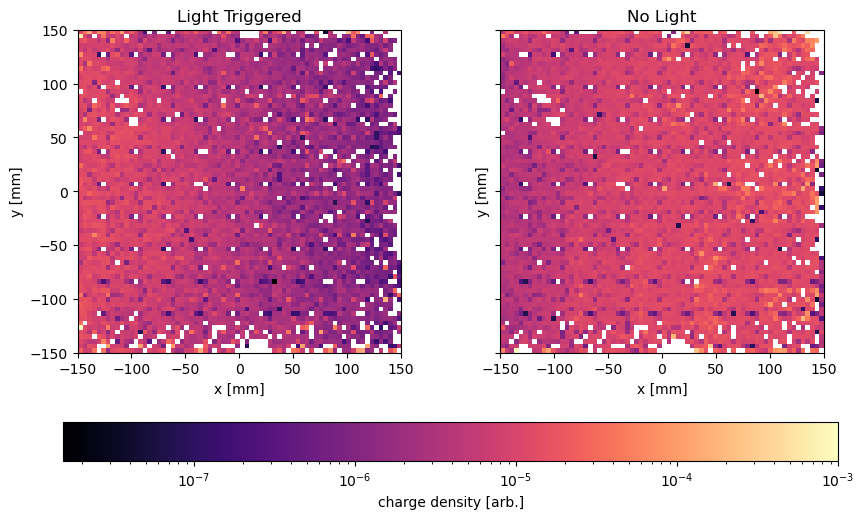

In [274]:
import matplotlib
_cmap = 'magma'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
vals, bins = np.histogramdd(np.array([x, y]).transpose(), weights=q, bins=(70, 70), density=True)
vals[vals==0]=np.nan
vals[vals>1e-3]=1e-3
#norm, bins = np.histogramdd(np.array([x, y]).transpose(), bins=(70, 70))
ax1.imshow(vals.T, origin='lower', extent=[-150., 150., -150., 150.], cmap=_cmap,norm=matplotlib.colors.LogNorm())
ax1.set_title('Light Triggered')
#plt.colorbar(im, ax=ax2)
vals, bins = np.histogramdd(np.array([xp, yp]).transpose(), weights=qp, bins=(70, 70), density=True)
#norm, bins = np.histogramdd(np.array([xp, yp]).transpose(), bins=(70, 70))
vals[vals==0]=np.nan
vals[vals>1e-3]=1e-3
im = ax2.imshow(vals.T, origin='lower', extent=[-150., 150., -150., 150.], cmap=_cmap, norm=matplotlib.colors.LogNorm())
ax2.set_title('No Light')
plt.colorbar(im, ax=[ax1, ax2], label='charge density [arb.]', orientation='horizontal')
ax1.set_xlabel('x [mm]')
ax2.set_xlabel('x [mm]')
ax1.set_ylabel('y [mm]')
ax2.set_ylabel('y [mm]')

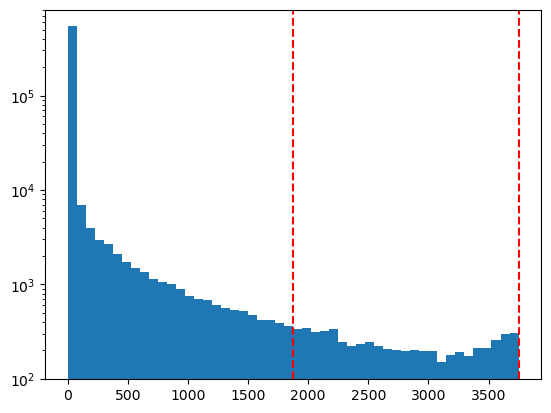

In [422]:
fig=plt.figure()
ax = fig.add_subplot()
plt.hist(mdiff, bins=50);
plt.yscale('log')
ax.axvline(max_ts_diff, linestyle='--', color='red')
ax.axvline(max_ts_diff*2, linestyle='--', color='red')

In [15]:
nhits_light = []
timespread_light = []
MAX_N_EVENT = int(5e6)
chans = np.ones( (MAX_N_EVENT, 12) )*-1
ts = np.ones( (MAX_N_EVENT, 12) )*-1
dws = np.ones( (MAX_N_EVENT, 12) )*-1
ts_same = np.ones( (int(MAX_N_EVENT/20), 12) )*-1
ievt=0
its_same = 0
for file in tqdm(list(nominal_files)):
    if ievt > MAX_N_EVENT-1: break
    f = h5py.File(file)
    #Loop for light events
    for evt in (set(f['light_event'])-set([-1])):
        lmask = f['light_event']==evt
        chan = np.array( f['light_chanid'][lmask] )
        chans[ievt][:chan.size] = chan
        
        t = np.array( f['light_ts'][lmask] )
        ts[ievt][:t.size] = t
        
        dw = np.array( f['light_data'][lmask] )
        dws[ievt][:dw.size] = dw
        
        t0 = np.min(f['light_ts'][lmask])
        tmax = np.max(f['light_ts'][lmask])
        
        tss = t==t0
        if np.sum(tss) > 1:
            ts_same[its_same][:np.sum(tss)] = dw[tss]
            its_same +=1
        
        nhits_light.append(np.sum(lmask))
        timespread_light.append(tmax-t0)
        ievt+=1
        if ievt > MAX_N_EVENT-1: break

 33%|███▎      | 73/221 [09:02<18:19,  7.43s/it]


KeyboardInterrupt: 

In [16]:
light_channels = [20, 18, 16, 14, 4, 2, 0, 62, 52, 50, 46, 44]
light_channel_index = np.ones(N_CHANNELS)*-1

for ich, channel in enumerate(light_channels):
    light_channel_index[channel] = ich

#Gives TOP to BOTTOM numbering of channels
light_channel_index = light_channel_index.astype(int)

chans_corr = np.zeros( (12, 12) )
counts = np.zeros( (12) )
chans_n    = np.ones( (12, MAX_N_EVENT))*-1

for ievt in tqdm(range(chans.shape[0])):
    ch = chans[ievt]
    ch = ch[ch >= 0]
    if ch.shape[0]==0: break
    for ich in range(len(light_channels)):
        if light_channels[ich] in ch:
            counts[ich] += 1
            for c in ch.astype(int):
                chans_corr[ich][light_channel_index[c]]+=1
            chans_n[ich][ievt] = ch.shape[0]
    

  8%|▊         | 386193/5000000 [00:19<03:47, 20311.83it/s]


Text(0, 0.5, 'density [arb.]')

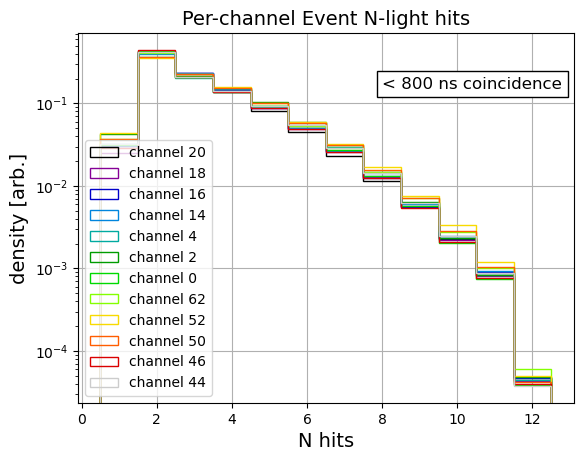

In [24]:
fig = plt.figure()
ax = fig.add_subplot()
colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, 12))
ax.set_prop_cycle('color', colors)
for ich in range(len(chans_n)):
    ax.hist(chans_n[ich]-0.5, range=(0.5,12.5), bins=12, label='channel {}'.format(light_channels[ich]), histtype='step', density=True)
plt.legend()
ax.text(8, 0.15, '< 800 ns coincidence', fontsize=12, bbox={'edgecolor' : 'black', 'facecolor':'white'})
plt.grid(True)
plt.yscale('log')
ax.set_title('Per-channel Event N-light hits', fontsize=14)
ax.set_xlabel('N hits', fontsize=14)
ax.set_ylabel('density [arb.]', fontsize=14)

Text(0.5, 1.0, 'Light Channel Trigger Correlations')

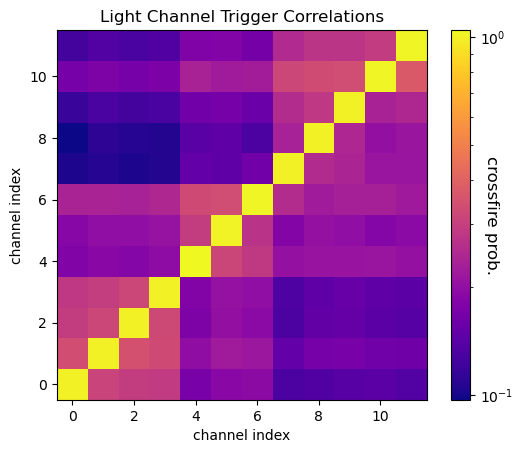

In [426]:
fig=plt.figure()
ax = fig.add_subplot()
im = plt.imshow(chans_corr/counts, origin='lower', norm=matplotlib.colors.LogNorm(), cmap='plasma')
cb = plt.colorbar(im, ax=ax)
cb.set_label("crossfire prob.", labelpad=-10, fontsize=12, rotation=270)
#ax.axhline(3.5, linestyle='--')
#ax.axhline(6.5, linestyle='--')
#ax.axvline(3.5, linestyle='--')
#ax.axvline(6.5, linestyle='--')
plt.xlabel('channel index')
plt.ylabel('channel index')
plt.title('Light Channel Trigger Correlations')

In [365]:
counts

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

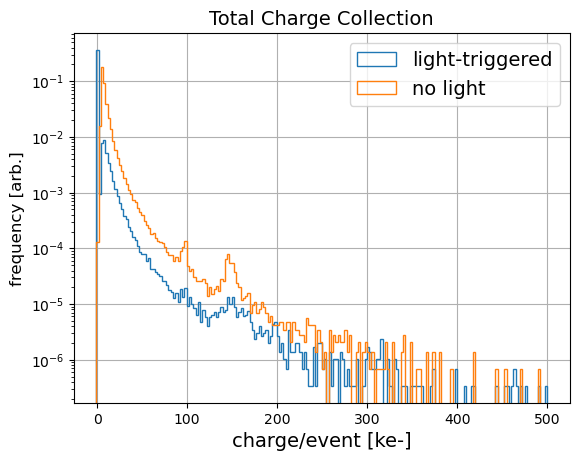

In [409]:
fig = plt.figure()
ax2 = fig.add_subplot()
ax2.set_title('Total Charge Collection',fontsize=14)
ax2.hist(np.array(ns)-0.5, bins=200, range=(-1, 500), histtype='step', density=True, label='light-triggered')
ax2.hist(np.array(ns_pre)-0.5, bins=200, range=(-1, 500), histtype='step', density=True, label='no light')
ax2.set_xlabel('charge/event [ke-]',fontsize=14)
ax2.set_yscale('log')
ax2.set_ylabel('frequency [arb.]',fontsize=12)
ax2.legend(fontsize=14)
ax2.grid(True)


In [462]:
std = []
diff = []
_max = np.max(ts_same)
for it in tqdm(range(its_same)):
    mask = ts_same[it] > -1
    diff.append(max(ts_same[it][mask]) - min(ts_same[it][mask]) )
    std.append(np.std(ts_same[it][mask]))

100%|██████████| 163157/163157 [00:03<00:00, 45144.61it/s]


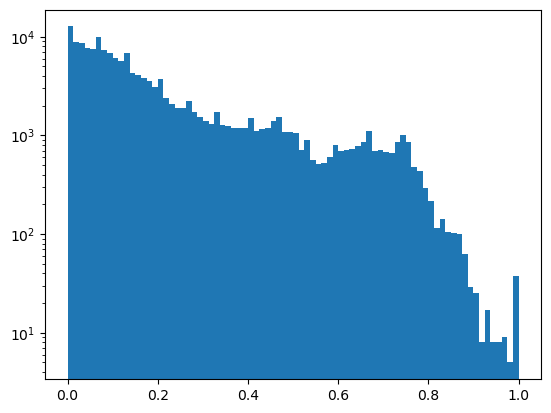

In [465]:
fig = plt.figure()
plt.hist(np.array(diff)/_max, bins=80, range=(0, 1));
plt.yscale('log')

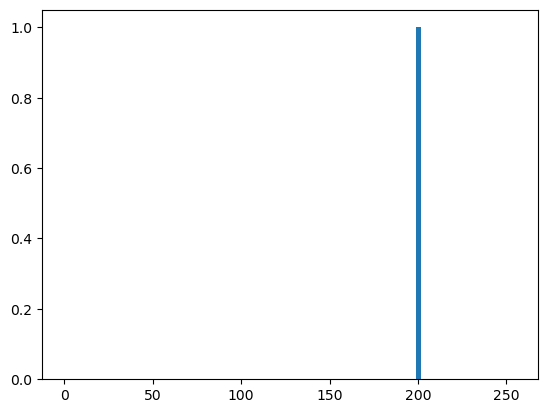

In [477]:
plt.hist(f['light_data'][f['light_chanid']==54].astype(float), bins=100, range=(0,255));


In [514]:
ld = []
chann = []
ievt=0
its_same = 0
for file in tqdm(list(nominal_files)):
    if ievt > MAX_N_EVENT-1: break
    f = h5py.File(file)
    ld += list(f['light_data'])
    chann += list(f['light_chanid'])

100%|██████████| 221/221 [01:58<00:00,  1.86it/s]


Text(0.5, 0.98, 'Channel TDC word Distributions')

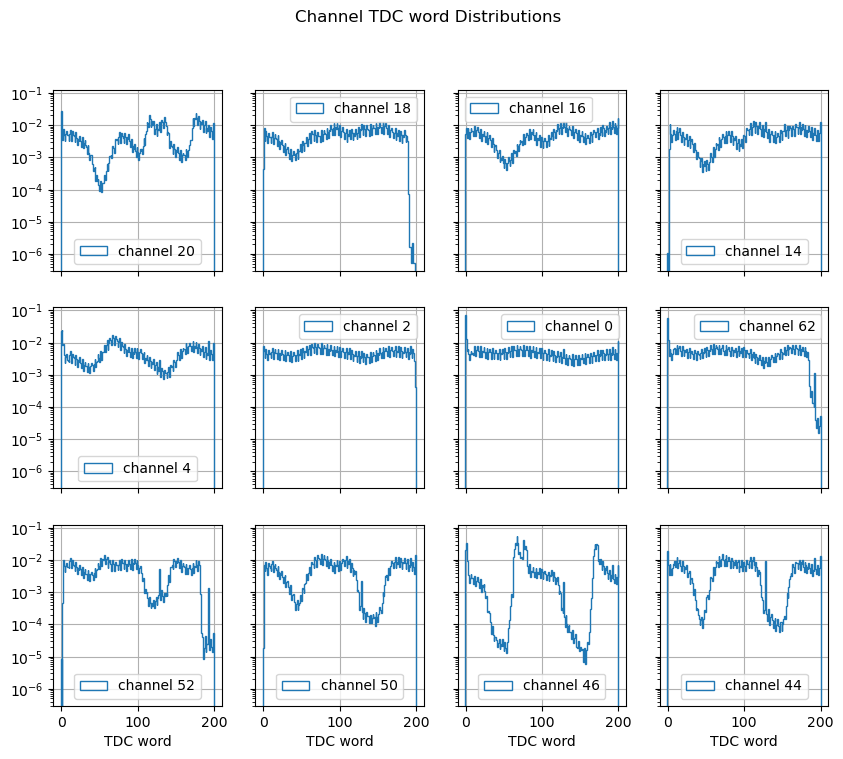

In [521]:
ld = np.array(ld)
chann = np.array(chann)
fig, axs = plt.subplots(3, 4, figsize=(10, 8), sharex=True, sharey=True)
for ich in range(len(chans_n)):
    #colormap = plt.cm.nipy_spectral
    #colors = colormap(np.linspace(0, 1, 12))
    #ax.set_prop_cycle('color', colors)
    axs.flatten()[ich].hist(ld[chann==light_channels[ich]], range=(-0.5, 200), bins=200, label='channel {}'.format(light_channels[ich]), histtype='step', density=True)
    axs.flatten()[ich].legend()
    axs.flatten()[ich].grid(True)
    axs.flatten()[ich].set_yscale('log')
    if ich > 7:
        axs.flatten()[ich].set_xlabel('TDC word')
fig.suptitle('Channel TDC word Distributions')

In [1]:
len(ld)

NameError: name 'ld' is not defined

In [511]:
len(chann)

5985206

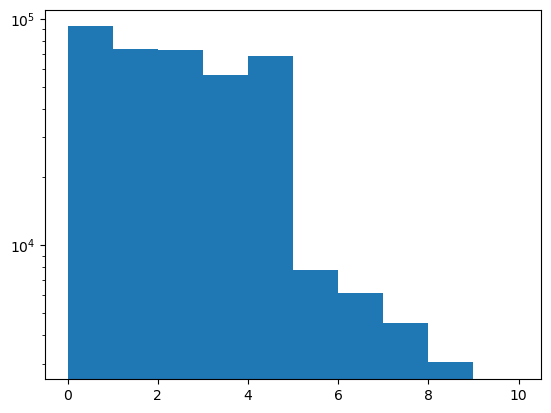

In [29]:
plt.hist(timespread_light, range=(0,10),bins=10)
plt.yscale('log')